In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error , r2_score
import joblib
%matplotlib inline

In [83]:
data = pd.read_csv('https://raw.githubusercontent.com/logan0501/Datasets/main/T1.csv')
data.rename(columns = {'LV ActivePower (kW)':'ActivePower(kW)',
                       "Wind Speed (m/s)":"WindSpeed(m/s)",
                       "Wind Direction (°)":"WindDirection","Theoretical_Power_Curve (KWh)":"TheoreticalPowerCurve(KWh)"},
            inplace = True)
data.head()

,Date/Time,ActivePower(kW),WindSpeed(m/s),TheoreticalPowerCurve(KWh),WindDirection
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [84]:
data.shape

(50530, 5)

In [85]:
data.describe()

,ActivePower(kW),WindSpeed(m/s),TheoreticalPowerCurve(KWh),WindDirection
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date/Time                   50530 non-null  object 
 1   ActivePower(kW)             50530 non-null  float64
 2   WindSpeed(m/s)              50530 non-null  float64
 3   TheoreticalPowerCurve(KWh)  50530 non-null  float64
 4   WindDirection               50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [87]:
data.isnull().any()

Date/Time                     False
ActivePower(kW)               False
WindSpeed(m/s)                False
TheoreticalPowerCurve(KWh)    False
WindDirection                 False
dtype: bool

## Data Preprocessing

In [88]:
data['Date/Time'] = pd.to_datetime(data['Date/Time'],format='%d %m %Y %H:%M')
data['year'] = data['Date/Time'].dt.year 
data['month'] = data['Date/Time'].dt.month 
data['day'] = data['Date/Time'].dt.day
data['Hour'] = data['Date/Time'].dt.hour 
data['minute'] = data['Date/Time'].dt.minute 
data.head()

,Date/Time,ActivePower(kW),WindSpeed(m/s),TheoreticalPowerCurve(KWh),WindDirection,year,month,day,Hour,minute
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,2018,1,1,0,0
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,2018,1,1,0,10
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,2018,1,1,0,20
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,2018,1,1,0,30
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,2018,1,1,0,40


In [89]:
#converting to nearby 0.5 or 0.0
#Normalization
def mean_speed(x):
    x = round(x,2)
    a = x//1
    a,b = a+0.25,a+0.75
    if x < a:
        x = a - 0.25
    else:
        x = b -0.25
    return x

In [90]:
data['meanSpeed'] = data['WindSpeed(m/s)'].apply(mean_speed)
data.head()

,Date/Time,ActivePower(kW),WindSpeed(m/s),TheoreticalPowerCurve(KWh),WindDirection,year,month,day,Hour,minute,meanSpeed
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,2018,1,1,0,0,5.5
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,2018,1,1,0,10,5.5
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,2018,1,1,0,20,5.0
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,2018,1,1,0,30,5.5
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,2018,1,1,0,40,5.5


In [91]:
def mean_direction(x):
    list=[]
    i=15
    while i<=375:
        list.append(i)
        i+=30
        
    for i in list:
        if x < i:
            x=i-15
            if x==360:
                return 0
            else:
                return x

In [92]:
data["meanDirection"]=data["WindDirection"].apply(mean_direction)
data

,Date/Time,ActivePower(kW),WindSpeed(m/s),TheoreticalPowerCurve(KWh),WindDirection,year,month,day,Hour,minute,meanSpeed,meanDirection
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,2018,1,1,0,0,5.5,270
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,2018,1,1,0,10,5.5,270
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,2018,1,1,0,20,5.0,270
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,2018,1,1,0,30,5.5,270
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,2018,1,1,0,40,5.5,270
...,...,...,...,...,...,...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,2018,12,31,23,10,11.5,90
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,2018,12,31,23,20,7.5,90
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,2018,12,31,23,30,8.5,90
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,2018,12,31,23,40,9.5,90


In [100]:
directiondict = {0:"N", 30:"NNE", 60:"NEE", 90:"E", 120:"SEE", 150:"SSE", 180:"S", 210:"SSW", 240:"SWW", 270:"W", 300:"NWW", 330:"NNW"}

def wind_direction(x):
    return directiondict[x]

In [101]:
data['windCDirection'] = data['meanDirection'].apply(wind_direction)
data

,Date/Time,ActivePower(kW),WindSpeed(m/s),TheoreticalPowerCurve(KWh),WindDirection,year,month,day,Hour,minute,meanSpeed,meanDirection,windCDirection
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,2018,1,1,0,0,5.5,270,W
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,2018,1,1,0,10,5.5,270,W
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,2018,1,1,0,20,5.0,270,W
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,2018,1,1,0,30,5.5,270,W
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,2018,1,1,0,40,5.5,270,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,2018,12,31,23,10,11.5,90,E
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,2018,12,31,23,20,7.5,90,E
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,2018,12,31,23,30,8.5,90,E
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,2018,12,31,23,40,9.5,90,E


In [ ]:
data.windCDirection.value_counts()

In [ ]:
data.describe()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


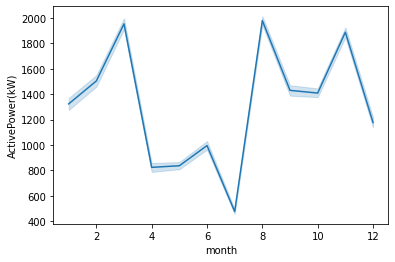

In [115]:
sns.lineplot(data.month,data['ActivePower(kW)'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


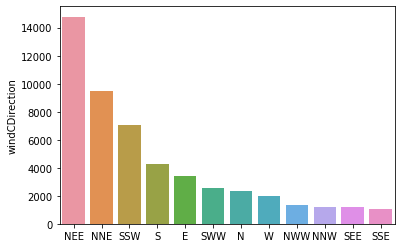

In [116]:
sns.barplot(data.windCDirection.value_counts().index, data.windCDirection.value_counts())

In [120]:
df = data[['month','day','Hour','meanSpeed','meanDirection','ActivePower(kW)']]
df.head()

,month,day,Hour,meanSpeed,meanDirection,ActivePower(kW)
0,1,1,0,5.5,270,380.047791
1,1,1,0,5.5,270,453.769196
2,1,1,0,5.0,270,306.376587
3,1,1,0,5.5,270,419.645905
4,1,1,0,5.5,270,380.650696


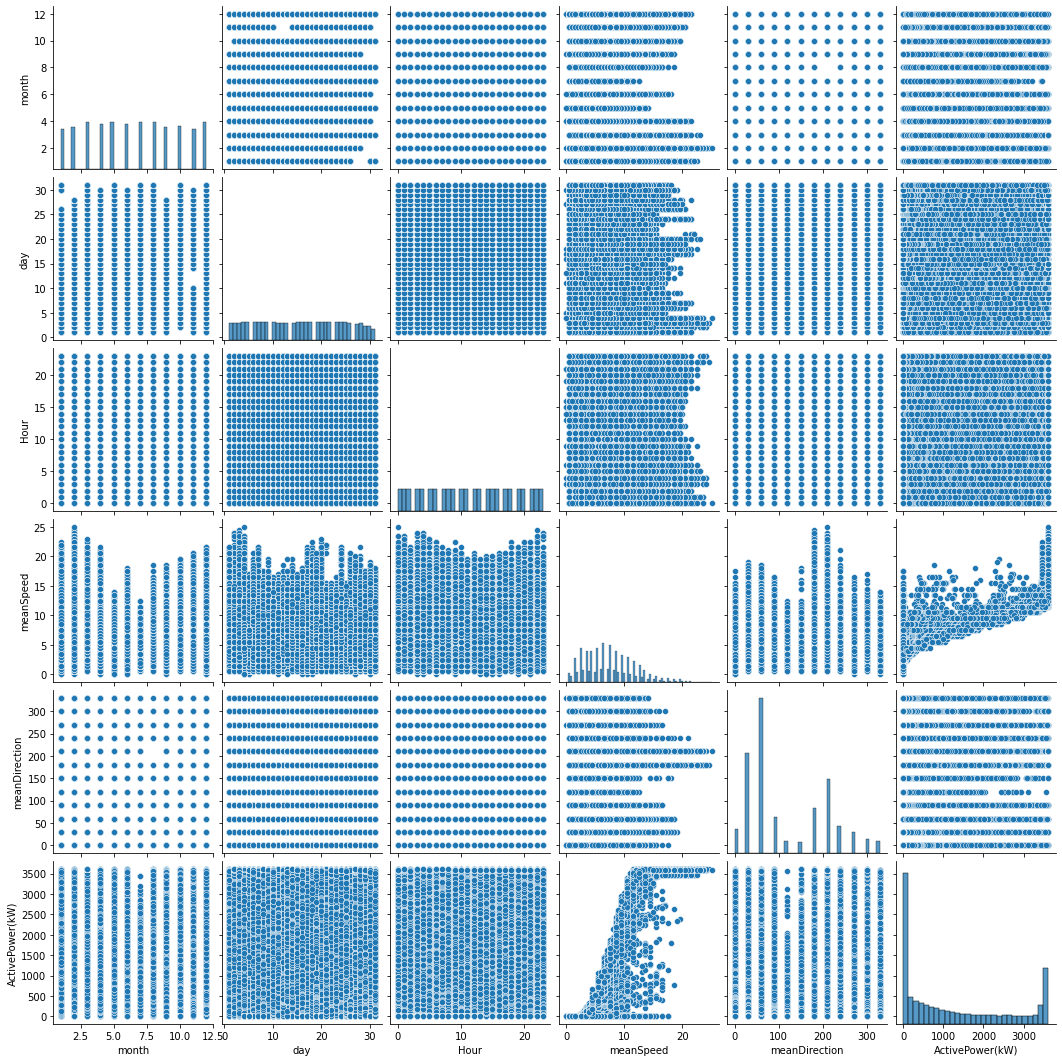

In [121]:
sns.pairplot(df)

In [122]:
df.corr()

,month,day,Hour,meanSpeed,meanDirection,ActivePower(kW)
month,1.000000,0.049584,0.001510,-0.013274,-0.195913,0.031010
day,0.049584,1.000000,-0.001882,0.000005,-0.019766,-0.007530
Hour,0.001510,-0.001882,1.000000,0.024543,-0.005810,0.036355
meanSpeed,-0.013274,0.000005,0.024543,1.000000,-0.036914,0.911803
meanDirection,-0.195913,-0.019766,-0.005810,-0.036914,1.000000,-0.028036
ActivePower(kW),0.031010,-0.007530,0.036355,0.911803,-0.028036,1.000000


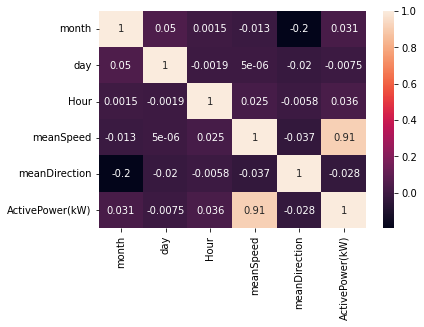

In [124]:
sns.heatmap(df.corr(),annot=True)